## **Distil BERT**

In [ ]:
!pip install transformers datasets scikit-learn pandas openpyxl
!pip install torch torchvision torchaudio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 24.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [ ]:
!pip install --upgrade transformers

### Importing Necessary Libraries

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler
from datasets import Dataset as HFDataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
import warnings
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load Train and Test datasets
train_val_df = pd.read_excel('/content/drive/MyDrive/INFO 617 Group Project Train Val.xlsx')
test_df = pd.read_excel('/content/drive/MyDrive/INFO 617_Group Project Test Set.xlsx')

print("Train/Val shape:", train_val_df.shape)
print("Test shape:", test_df.shape)


Train/Val shape: (4030, 2)
Test shape: (1187, 2)


### Data Preprocessing

As part of the preprocessing step, label encoding was applied to both the training and test datasets to convert the categorical text labels into numerical format. Using Scikit-learn's LabelEncoder, each unique label corresponding to different categories of medical conversation content (e.g., "TREAT", "EXPLAIN", "WISH") was assigned an integer value. This transformation was essential because machine learning models such as DistilBERT require numerical labels for classification tasks. A total of 15 unique classes were identified and encoded, including 'CONSOLE', 'DIAGNOISE', 'EXPLAIN', 'FUTURE_SUPPORT', 'GREET', 'QUES', 'RECEIVE', 'REFERRAL', 'REMIND', 'REPEAT', 'REQUEST_INFORMATION', 'THANK', 'TREAT', 'WAIT', and 'WISH'. Label encoding ensured that the model learned to classify medical conversation sentences based on a consistent and structured numerical target space, without introducing any artificial ordinal relationships between categories.

In [ ]:
# Label encode
label_encoder = LabelEncoder()
train_val_df['Label_encoded'] = label_encoder.fit_transform(train_val_df['Label'])
test_df['Label_encoded'] = label_encoder.transform(test_df['Label'])

print(label_encoder.classes_)


['CONSOLE' 'DIAGNOISE' 'EXPLAIN' 'FUTURE_SUPPORT' 'GREET' 'QUES' 'RECEIVE'
 'REFERRAL' 'REMIND' 'REPEAT' 'REQUEST_INFORMATION' 'THANK' 'TREAT' 'WAIT'
 'WISH']


### Data Segmentation
To prepare the data for model training and validation, the provided training dataset was split into training and validation subsets using an 80/20 stratified split. This was achieved with Scikit-learn’s train_test_split function, ensuring that 80% of the data was used for training the model and 20% was reserved for validation during training. Stratification was performed based on the encoded label values to maintain the original class distribution across both the training and validation sets.

In [ ]:
# 80/20 stratified split
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,
    random_state=42,
    stratify=train_val_df['Label_encoded']
)

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)


Train shape: (3224, 3)
Validation shape: (806, 3)


In [ ]:
train_df.head()

,Sentence,Label,Label_encoded
1406,Coughing and runny nose symptoms usually peak ...,EXPLAIN,2
1508,Stay safe and well.,WISH,14
2877,"Pay attention to your diet, and avoid eating s...",TREAT,12
799,Hello!,GREET,4
3428,"If symptoms do not improve, further electromyo...",REFERRAL,7


In [ ]:
val_df.head()

,Sentence,Label,Label_encoded
1523,"Oh, hello.",GREET,4
1441,"At this time, other possible infections or all...",REFERRAL,7
555,and I will answer your question as soon as pos...,WAIT,13
290,Topical ointments usually take effect in about...,EXPLAIN,2
2226,"In clinical practice, we generally explain al...",EXPLAIN,2


### Resampling
To address class imbalance in the training data, random oversampling was performed using the RandomOverSampler technique from the imblearn library. After the initial 80/20 split, it was observed that some conversation categories had significantly fewer examples compared to others. To ensure that the model received an equal opportunity to learn from all classes, oversampling was applied to the training split. Each class was upsampled to 950 examples, thereby creating a balanced training dataset across all 15 categories. This resampling strategy aimed to prevent the model from becoming biased toward majority classes during training and to improve the overall classification performance, particularly for minority categories.

In [ ]:
# Balance classes with Random Oversampling
ros = RandomOverSampler(random_state=42)

X_train = train_df['Sentence'].values.reshape(-1,1)
y_train = train_df['Label_encoded']

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Build new training dataframe
train_df_balanced = pd.DataFrame({
    'Sentence': X_resampled.flatten(),
    'Label_encoded': y_resampled
})

print(train_df_balanced['Label_encoded'].value_counts())


Label_encoded
2     950
14    950
12    950
4     950
7     950
9     950
11    950
10    950
8     950
13    950
5     950
3     950
0     950
1     950
6     950
Name: count, dtype: int64


In [ ]:
# Prepare datasets
train_dataset = HFDataset.from_pandas(train_df_balanced)
val_dataset = HFDataset.from_pandas(val_df[['Sentence', 'Label_encoded']])
test_dataset = HFDataset.from_pandas(test_df[['Sentence', 'Label_encoded']])

train_dataset = train_dataset.rename_columns({'Sentence': 'text', 'Label_encoded': 'labels'})
val_dataset = val_dataset.rename_columns({'Sentence': 'text', 'Label_encoded': 'labels'})
test_dataset = test_dataset.rename_columns({'Sentence': 'text', 'Label_encoded': 'labels'})


### Model Preparation, Tokenization, and Training
ClinicalBERT (emilyalsentzer/Bio_ClinicalBERT) was selected as the base model for fine-tuning. The associated tokenizer was used to preprocess the text data from the training, validation, and test sets, applying truncation and padding to ensure uniform sequence lengths. A sequence classification head was added to ClinicalBERT, configured for 15 target classes. Model training was performed using the HuggingFace Trainer API, with a batch size of 16, learning rate of 2e-5, weight decay of 0.01, and for a total of 5 epochs. The model was trained on the balanced training set and periodically evaluated on the validation set to monitor learning and adjust training dynamics.

In [ ]:
model_checkpoint = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_test = test_dataset.map(tokenize_function, batched=True, remove_columns=["text"])


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Map:   0%|          | 0/14250 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/806 [00:00<?, ? examples/s]

Map:   0%|          | 0/1187 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_encoder.classes_)
)


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results_clinicbert",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs_clinicbert",
    logging_steps=10
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
trainer.train()


Step,Training Loss
10,2.680600
20,2.607300
30,2.482800
40,2.353300
50,2.341100
60,2.164900
70,2.005800
80,1.899900
90,1.719900
100,1.604500


TrainOutput(global_step=4455, training_loss=0.15555141348063561, metrics={'train_runtime': 2024.4017, 'train_samples_per_second': 35.196, 'train_steps_per_second': 2.201, 'total_flos': 5829185272755996.0, 'train_loss': 0.15555141348063561, 'epoch': 5.0})

### Evaluation on Validation Set

In [ ]:
val_predictions = trainer.predict(tokenized_val)
y_pred_val = np.argmax(val_predictions.predictions, axis=1)
y_true_val = val_predictions.label_ids

print("=== Evaluation on Validation Set ===")
print("Accuracy:", accuracy_score(y_true_val, y_pred_val))
print("Precision (weighted):", precision_score(y_true_val, y_pred_val, average='weighted', zero_division=0))
print("Recall (weighted):", recall_score(y_true_val, y_pred_val, average='weighted', zero_division=0))
print("F1-Score (weighted):", f1_score(y_true_val, y_pred_val, average='weighted', zero_division=0))

print("\nClassification Report (Validation Set):\n")
print(classification_report(y_true_val, y_pred_val, target_names=label_encoder.classes_))


=== Evaluation on Validation Set ===
Accuracy: 0.815136476426799
Precision (weighted): 0.8125883233613973
Recall (weighted): 0.815136476426799
F1-Score (weighted): 0.8113062966304526

Classification Report (Validation Set):

                     precision    recall  f1-score   support

            CONSOLE       0.92      0.75      0.83        16
          DIAGNOISE       0.66      0.78      0.72        76
            EXPLAIN       0.78      0.75      0.76       212
     FUTURE_SUPPORT       0.83      0.71      0.77         7
              GREET       1.00      1.00      1.00        24
               QUES       0.94      0.96      0.95        53
            RECEIVE       0.92      1.00      0.96        22
           REFERRAL       0.72      0.75      0.73        44
             REMIND       0.80      0.75      0.77        16
             REPEAT       0.50      0.18      0.26        17
REQUEST_INFORMATION       0.60      0.55      0.57        11
              THANK       0.94      1.00  

After training, the model was evaluated on the validation set to assess its generalization performance. The DistilBERT model achieved an overall accuracy of 81.5%, with a weighted precision of 81.26%, recall of 81.51%, and a weighted F1-score of 81.13%. Most classes, such as "GREET," "QUES," "RECEIVE," and "THANK," demonstrated high precision and recall, indicating strong classification performance. However, certain classes like "REPEAT" and "REQUEST_INFORMATION" showed lower F1-scores, suggesting difficulty in distinguishing these categories due to their relatively small sample sizes. Overall, the validation results confirmed that the model was learning the underlying patterns effectively while maintaining balanced performance across most categories.



### Evaluation on Test Set

In [ ]:
test_predictions = trainer.predict(tokenized_test)
y_pred_test = np.argmax(test_predictions.predictions, axis=1)
y_true_test = test_predictions.label_ids

print("=== Final Evaluation on Test Set ===")
print("Accuracy:", accuracy_score(y_true_test, y_pred_test))
print("Precision (weighted):", precision_score(y_true_test, y_pred_test, average='weighted', zero_division=0))
print("Recall (weighted):", recall_score(y_true_test, y_pred_test, average='weighted', zero_division=0))
print("F1-Score (weighted):", f1_score(y_true_test, y_pred_test, average='weighted', zero_division=0))

print("\nClassification Report (Test Set):\n")
print(classification_report(y_true_test, y_pred_test, target_names=label_encoder.classes_))


=== Final Evaluation on Test Set ===
Accuracy: 0.8171861836562764
Precision (weighted): 0.8197334131514731
Recall (weighted): 0.8171861836562764
F1-Score (weighted): 0.8142974955595612

Classification Report (Test Set):

                     precision    recall  f1-score   support

            CONSOLE       0.88      0.78      0.82        27
          DIAGNOISE       0.72      0.66      0.69       119
            EXPLAIN       0.78      0.67      0.72       316
     FUTURE_SUPPORT       0.78      0.88      0.82         8
              GREET       1.00      1.00      1.00        29
               QUES       0.98      0.98      0.98       109
            RECEIVE       1.00      0.92      0.96        37
           REFERRAL       0.79      0.85      0.82        74
             REMIND       0.86      0.90      0.88        21
             REPEAT       0.59      0.57      0.58        30
REQUEST_INFORMATION       0.85      0.55      0.67        20
              THANK       0.95      0.98      

The final model evaluation was conducted on the unseen test set to assess its true generalization performance. The DistilBERT model achieved an overall accuracy of 81.72%, with a weighted precision of 81.97%, recall of 81.72%, and a weighted F1-score of 81.43%. The model demonstrated strong classification capability across most categories, with particularly high precision and recall for labels such as "GREET," "QUES," "THANK," and "WAIT." However, some challenges remained for classes like "REPEAT" and "REQUEST_INFORMATION," where lower F1-scores indicated moderate difficulty in correctly classifying these categories. Overall, the model maintained consistent and balanced performance on the final test data, validating the effectiveness of the fine-tuning and resampling strategies applied during the training process.

### Learning Curve

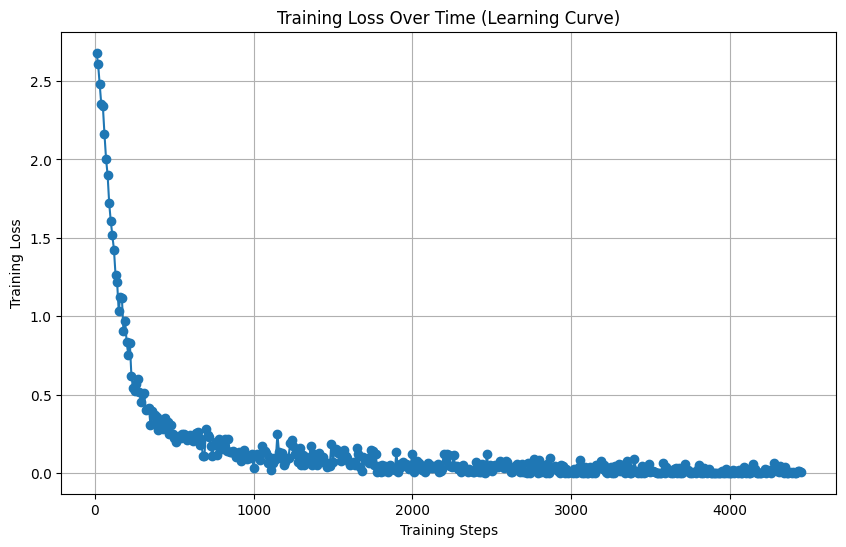

In [ ]:
# Plot training loss over steps
import matplotlib.pyplot as plt

# Extract training logs
training_logs = trainer.state.log_history

# Extract loss and steps
train_loss = [log["loss"] for log in training_logs if "loss" in log]
train_steps = [log["step"] for log in training_logs if "loss" in log]

# Plot
plt.figure(figsize=(10,6))
plt.plot(train_steps, train_loss, marker='o')
plt.xlabel('Training Steps')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Time (Learning Curve)')
plt.grid(True)
plt.show()


The training loss curve plotted over the course of training steps demonstrates a smooth and steady decrease in loss, indicating effective model learning. Initially, the loss dropped rapidly, reflecting that the model was quickly capturing basic patterns in the dataset. As training progressed, the rate of loss reduction slowed, eventually plateauing at a very low loss value close to zero. This behavior suggests that the model successfully minimized training error without major signs of overfitting or instability. The absence of sharp spikes or oscillations in the curve further confirms that the learning process was stable throughout the training phase.

### Confusion Matrix

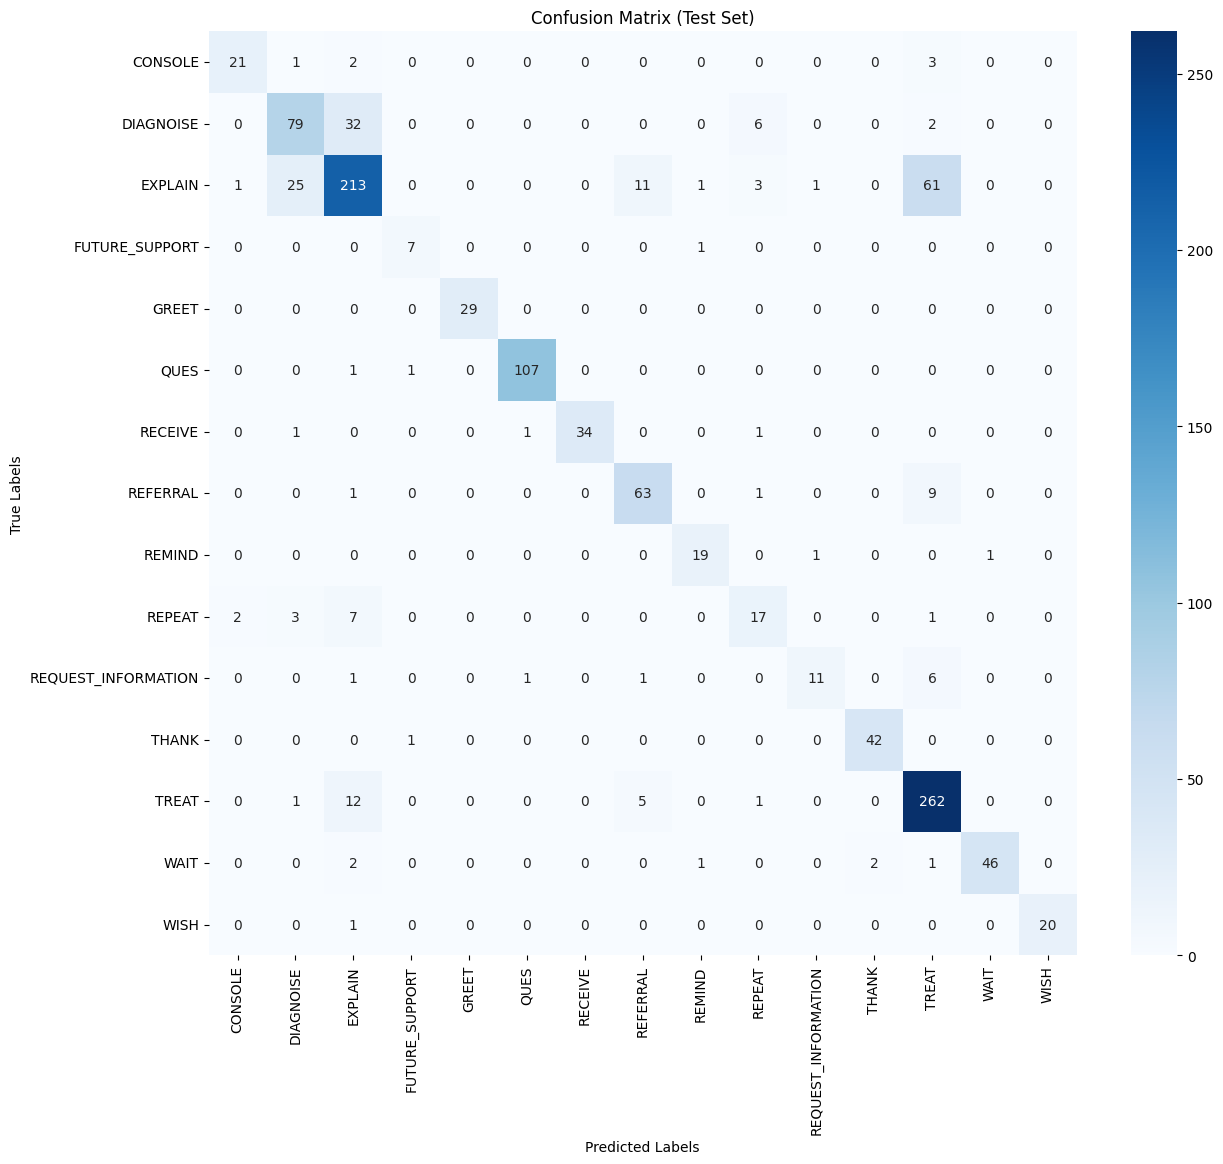

In [ ]:
# Confusion matrix for Test Set
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)

# Plot
plt.figure(figsize=(14,12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Test Set)')
plt.show()


The confusion matrix for the test set illustrates the model’s ability to correctly classify sentences across the 15 medical conversation categories. Most classes such as "GREET," "QUES," "THANK," and "WAIT" show strong diagonal dominance, indicating high true positive rates. However, certain classes like "DIAGNOISE," "EXPLAIN," and "REPEAT" exhibit notable off-diagonal values, suggesting occasional misclassifications. For instance, instances of "DIAGNOISE" were sometimes misclassified as "EXPLAIN," and "REPEAT" showed confusion across several neighboring categories. Despite a few overlaps, the overall matrix remains largely sparse, confirming that the model maintained good discriminative capability across most categories. These results are consistent with the classification report, reinforcing the model’s balanced yet slightly challenging performance for certain overlapping classes.